In [1]:
# STUDENT NUMBERS
# 2138802
from IPython.display import JSON
from google.colab import output
from subprocess import getoutput
import os

def shell(command):
  if command.startswith('cd'):
    path = command.strip().split(maxsplit=1)[1]
    os.chdir(path)
    return JSON([''])
  return JSON([getoutput(command)])
output.register_callback('shell', shell)

In [2]:
# Solution to install minihack in google colab
!sudo apt update
!sudo apt install -y build-essential autoconf libtool pkg-config python3-dev \
    python3-pip python3-numpy git flex bison libbz2-dev

!wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | sudo apt-key add -
!sudo apt-add-repository 'deb https://apt.kitware.com/ubuntu/ bionic main'
!sudo apt-get update && apt-get --allow-unauthenticated install -y \
    cmake \
    kitware-archive-keyring

# feel free to use a more elegant solution to make /usr/bin/cmake the default one
!sudo rm $(which cmake)
!$(which cmake) --version

# Install minihack
!pip install minihack

# install colabgymrender
!apt-get install-y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install imageio==2.4.1

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [96.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:14 http:

In [3]:
import torch
from google.colab import drive

drive.mount('/content/drive')

import sys
sys.path.insert(0,"/content/drive/MyDrive/Colab Notebooks/RL_Ass/test_reinforce")

Mounted at /content/drive


Reinforce with baseline -> episode: 0, total reward: -6.54, average_reward: -6.54, length: 999
Reinforce with baseline -> episode: 10, total reward: -6.02, average_reward: -6.554, length: 999
Reinforce with baseline -> episode: 20, total reward: -5.94, average_reward: -6.476, length: 999
Reinforce with baseline -> episode: 30, total reward: -5.72, average_reward: -6.487, length: 999
Reinforce with baseline -> episode: 40, total reward: -6.52, average_reward: -6.692, length: 999
Reinforce with baseline -> episode: 50, total reward: -6.0, average_reward: -5.708, length: 999
Reinforce with baseline -> episode: 60, total reward: -8.16, average_reward: -6.341, length: 965
Reinforce with baseline -> episode: 70, total reward: -6.2, average_reward: -6.411, length: 999
Reinforce with baseline -> episode: 80, total reward: -6.48, average_reward: -6.802, length: 999
Reinforce with baseline -> episode: 90, total reward: -6.2, average_reward: -6.443, length: 999
Reinforce with baseline -> episode:

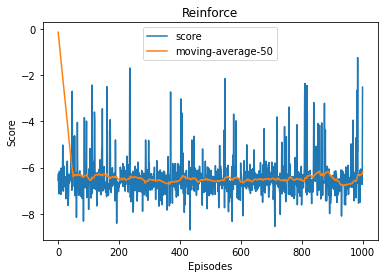

In [6]:
# This code was formed with the help of the following github repositories:
# https://gist.github.com/cyoon1729/bc41d466b868ea10e794a7c04321ff3b#file-reinforce_model-py
# https://gist.github.com/cyoon1729/3920da556f992909ace8516e2f321a7c#file-reinforce_update-py
# https://github.com/chengxi600/RLStuff/blob/master/Policy%20Gradients/REINFORCE-Baseline.ipynb
# https://github.com/mikevogt/RL-Project--Minihack-Quest-Hard-v0/blob/main/Agents/REINFORCE/main.py

import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque
from torch.autograd import Variable
import minihack
import sys
import math
from nle import nethack
from minihack import RewardManager
from colabgymrender.recorder import Recorder
import cv2
from wrappers import RenderRGB
from value_model import ValueNetwork
from policy_model import PolicyNetwork
cv2.ocl.setUseOpenCL(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

def compute_returns_naive_baseline(rewards, gamma): #
    returns = []
    #calculates the return values
    for t in range(len(rewards)):
        target = 0
        for r in rewards[t:]:
            target = target * gamma + r
        returns.append(target)
    returns = torch.tensor(returns).to(device)
    returns = (returns - returns.mean()) / (
        returns.std())
    return returns

def learning(states ,scores, value_network, policy_network, log_probababilities, env, gamma):
    returns = compute_returns_naive_baseline(scores, gamma)
    
    # Initialisations
    values_list = []
    derivatives = []
    gradients = []

    for i in states:
        values_list.append(value_network.forward(Variable(i)))
    values_list = torch.stack(values_list).squeeze()
    _loss = F.mse_loss(values_list, returns)
    value_network.adam.zero_grad()
    _loss.backward()
    # optimise value network step
    value_network.adam.step()

    for target, val in zip(returns, values_list):
        derivatives.append(target-val)
    derivatives = torch.tensor(derivatives).to(device)

    for log_probability, derivative in zip(log_probababilities, derivatives):
        gradients.append(-log_probability*derivative)
    policy_network.adam.zero_grad()
    gradients = torch.stack(gradients).sum()
    gradients.backward()
    # optimise policy network step
    policy_network.adam.step()

def reinforce_naive_baseline(env, policy_network, value_network, seed,
                             number_episodes,
                             max_episode_length,
                             gamma, verbose=True): #
    global hyper_params
    torch.manual_seed(hyper_params['seed'])
    torch.cuda.manual_seed_all(hyper_params['seed'])
    np.random.seed(hyper_params['seed'])
    random.seed(hyper_params['seed'])
    env.seed(hyper_params['seed'])
    policy = []
    numsteps = []
    avgNumsteps = []
    allRewards = []
    for episode in range(number_episodes):
        state = env.reset()['glyphs_crop']
        log_probababilities = []
        scores = []
        states = []
        for steps in range(max_episode_length):
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            probabilities = policy_network.forward(Variable(state))
            action = np.random.choice(env.action_space.n, p=np.squeeze(probabilities.cpu().detach().numpy()))
            _log_probabilities = torch.log(probabilities.squeeze(0)[action])
            next_state, score, done, _ = env.step(action)
            log_probababilities.append(_log_probabilities)
            scores.append(score)
            states.append(state)
            if steps%100==0:
                p = 0
            if done:
                learning(states, scores, value_network, policy_network, log_probababilities, env, gamma)
                numsteps.append(steps)
                avgNumsteps.append(np.mean(numsteps[-10:]))
                allRewards.append(np.sum(scores))
                if verbose:
                    if episode % 10 == 0:
                        print("Reinforce with baseline -> episode: {}, total reward: {}, average_reward: {}, length: {}".format(episode,np.round(
                                                                                                                  np.sum(
                                                                                                                      scores),
                                                                                                                  decimals=3),
                                                                                                              np.round(
                                                                                                                  np.mean(
                                                                                                                      allRewards[
                                                                                                                      -10:]),
                                                                                                                  decimals=3),
                                                                                                      steps))
                break
            state = next_state['glyphs_crop']
    env.close()
    return policy, allRewards

def makeEnv(): #
    global hyper_params
    MOVE_ACTIONS = tuple(nethack.CompassDirection)
    NAVIGATE_ACTIONS = MOVE_ACTIONS + (nethack.Command.OPEN,nethack.Command.KICK,nethack.Command.FIRE,nethack.Command.ZAP,nethack.Command.SEARCH, nethack.Command.PICKUP,nethack.Command.WIELD, nethack.Command.SWAP,nethack.Command.JUMP,nethack.Command.EAT,nethack.Command.WEAR,nethack.Command.ENHANCE)

    reward_manager = RewardManager()
    reward_manager.add_eat_event("apple", reward=1)
    reward_manager.add_amulet_event(reward=1)
    reward_manager.add_kill_event("demon",reward=1)
    reward_manager.add_kill_event("monster",reward=1)
    reward_manager.add_kill_event("minotaur", reward=10)
    reward_manager.add_wield_event("wand", reward=2)
    reward_manager.add_kill_event("jackal", reward=1)
    reward_manager.add_location_event("sink", reward=-1)
    reward_manager.add_kill_event("goblin", reward=1)
    reward_manager.add_message_event("The door opens.", reward=1)
    reward_manager.add_kill_event("giant rat", reward=1)

    # making gym environment
    env = gym.make(
        hyper_params["env-name"],
        observation_keys=("pixel_crop","glyphs_crop","glyphs","pixel","blstats","message","inv_strs",),
        actions=NAVIGATE_ACTIONS,
        reward_lose=-10,
        reward_win=5,
        penalty_step = -0.01,
        penalty_time = 0.01,
        reward_manager=reward_manager,
        max_episode_steps = hyper_params['num-steps']
    )
    env.seed(hyper_params["seed"])
    env = RenderRGB(env, "pixel_crop")
    # To record video
    env = Recorder(env, '/content/drive/MyDrive/Colab Notebooks/RL_Ass/test_reinforce/videos', 30)
    return env

def run_reinforce(verbose=False):
    global hyper_params
    env = makeEnv()
    size = 81
    policy_network = PolicyNetwork(s_size=size, h_size=size, a_size=env.action_space.n,learning_rate=hyper_params['learning-rate']).to(device)
    value_network = ValueNetwork(s_size=size, h_size=size,learning_rate=hyper_params['learning-rate']).to(device)
    _, scores = reinforce_naive_baseline(env=env, policy_network=policy_network, value_network=value_network, seed=42,
                               number_episodes=1000,
                               max_episode_length=hyper_params['num-steps'],
                               gamma=hyper_params['discount-factor'],
                               verbose=verbose)
    # Plot learning curve
    moving_avg = moving_average(scores, 50)
    plt.plot(scores, label="score")
    plt.plot(moving_avg, label="moving-average-50")
    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Reinforce")
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/RL_Ass/test_reinforce/reinforcelr.png')
    plt.show()


if __name__ == '__main__':
    hyper_params = {
        "seed": 42,  # which seed to use
        "env-name": "MiniHack-Quest-Hard-v0",  # name of the game
        "learning-rate": 1e-4,  # learning rate for Adam optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(5e6), # total number of steps to run the environment for
    }
    run_reinforce(verbose=True)